In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
from scipy import stats
import xgboost as xgb # XGBoost 라이브러리
from sklearn.model_selection import train_test_split # 데이터 분할
from sklearn.metrics import mean_squared_error, r2_score # 회귀 모델 평가 지표
from sklearn.preprocessing import StandardScaler # 스케일링 (선택적)
from sklearn.pipeline import Pipeline # 전처리 및 모델링 파이프라인
from sklearn.impute import SimpleImputer # 결측치 처리를 위한 Imputer (XGBoost 자체 기능 대신 사용 예시)

plt.rcParams['font.family'] = 'Malgun Gothic'
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [403]:
gdf = gpd.read_file("C:/Users/User/Desktop/파이썬/연습문제/venv/practical_project/csv/point_1.shp")

In [404]:
df = pd.read_csv("C:/Users/User/Desktop/파이썬/연습문제/venv/실전프로젝트/farm.csv", encoding="cp949")

In [405]:
df["농장아이디"].unique()

array([20278, 20338, 20261, 20279, 20332, 21133, 20264])

In [406]:
df_drop = df[df["농장아이디"]==20261].index
df.drop(df_drop, inplace=True)

In [407]:
df.drop("체세포", axis=1, inplace=True)
df.drop("수집건수", axis=1, inplace=True)
df.drop("측정일시", axis=1, inplace=True)
df.drop("축종코드", axis=1, inplace=True)
df.drop("제조사 아이디", axis=1, inplace=True)
df.drop("수집일자", axis=1, inplace=True)

In [408]:
# 혈액흐름 전처리
df["혈액흐름"] = df["혈액흐름"].apply(lambda x : 0 if x == "N" else 1)

In [409]:
df["착유시작일시"] = pd.to_datetime(df["착유시작일시"], format="%Y-%m-%d %H:%M")
df["착유종료일시"] = pd.to_datetime(df["착유종료일시"], format="%Y-%m-%d %H:%M")

In [410]:
df.head(10)

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름
0,20278,20130816010079,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5
1,20278,20130816010079,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1
2,20278,20130816010079,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9
3,20278,20130816010079,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7
4,20278,20130816010079,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3
5,20278,20130816010079,17,2021-09-03 00:11:00,2021-09-03 00:20:00,1,7.0,0,39.7,4.4,3.2,2.1
6,20278,20130816010079,12,2021-09-03 07:19:00,2021-09-03 07:28:00,2,6.9,0,39.4,4.7,3.1,1.7
7,20278,20130816010079,15,2021-09-03 16:30:00,2021-09-03 16:39:00,3,6.9,0,40.5,4.4,3.3,2.1
8,20278,20130816010079,14,2021-09-04 00:59:00,2021-09-04 01:10:00,1,6.8,0,39.6,4.6,3.1,1.6
9,20278,20130816010079,10,2021-09-04 07:01:00,2021-09-04 07:09:00,2,6.7,0,39.3,5.3,3.0,1.6


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


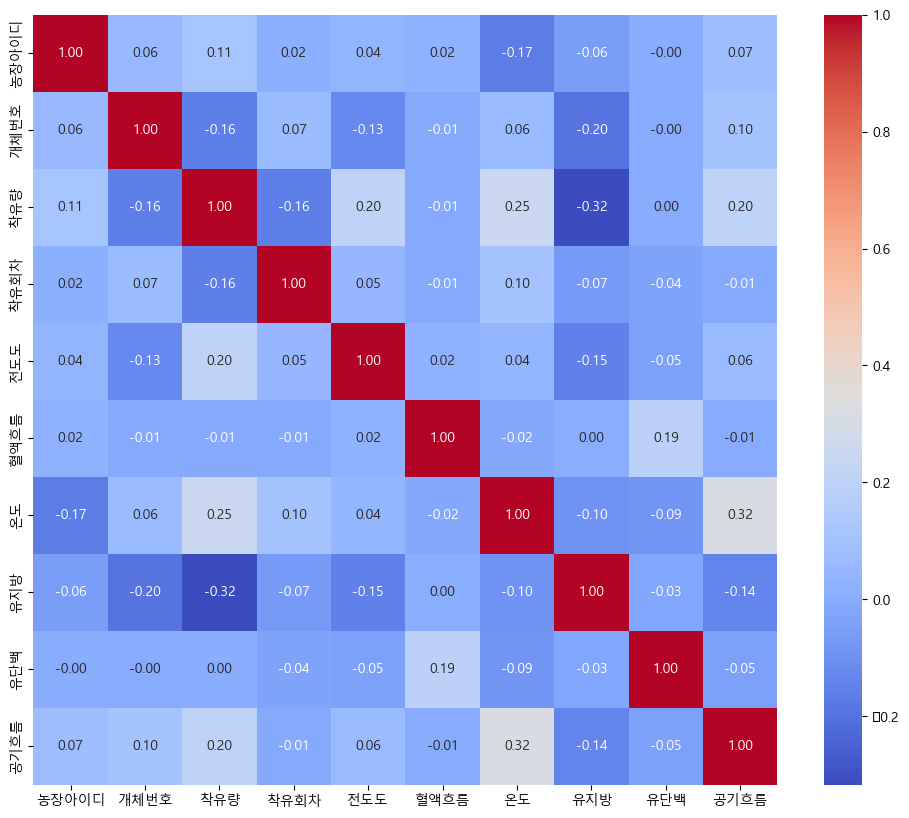

In [411]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap = "coolwarm")
plt.show()

# 파생변수

In [412]:
df["착유시간"] = df["착유종료일시"] - df["착유시작일시"]

In [413]:
df["착유시간"]  = df["착유시간"].dt.total_seconds() / 60  # 분 단위로 변환

In [414]:
# 가정 (개체번호 앞 7자리는 생년월일)
df_birth = df['개체번호'].astype(str).str[:8]
df_birthdt = pd.to_datetime(df_birth, format='%Y%m%d', errors='coerce')

def calculate_age(birth_date, current_date):

    # 만 나이 계산 로직
    # 현재 연도 - 출생 연도 - 불리언(생일이 현재 날짜보다 뒤에 있으면 1 빼기)
    age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    return age

current_analysis_date = datetime(2021, 10, 1)
df['나이'] = df_birthdt.apply(lambda x: calculate_age(x, current_analysis_date))

In [415]:
# 개체별 일일착유량 계산 
df["측정일"] = df["착유시작일시"].dt.day
df_count1 = df.groupby(["개체번호","측정일"])["착유량"].sum().reset_index()
df_count1.rename(columns={"착유량": "개체별 일일착유량"}, inplace=True)
df = df.merge(df_count1, on=["개체번호", "측정일"], how="left")

In [416]:
df["개체별 일일착유량"].isnull().sum()

np.int64(0)

In [417]:
# 개체별 착유일수 계산
df_count2 = df.groupby("개체번호")["측정일"].nunique().reset_index()
df_count2.rename(columns={"측정일": "개체별 착유일수"}, inplace=True)
df = df.merge(df_count2, on="개체번호", how="left")

In [222]:
df["개체별 착유일수"].isnull().sum()

np.int64(0)

In [418]:
df.head()

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간,나이,측정일,개체별 일일착유량,개체별 착유일수
0,20278,20130816010079,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5,12.0,8,1,33,26
1,20278,20130816010079,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1,9.0,8,1,33,26
2,20278,20130816010079,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9,10.0,8,2,35,26
3,20278,20130816010079,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7,8.0,8,2,35,26
4,20278,20130816010079,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3,12.0,8,2,35,26


In [ ]:
df.d

## 결측치

In [420]:
df.isnull().sum()

농장아이디         0
개체번호          0
착유량           0
착유시작일시        0
착유종료일시        0
착유회차          0
전도도           0
혈액흐름          0
온도            0
유지방          42
유단백          42
공기흐름          0
착유시간          0
나이            0
측정일           0
개체별 일일착유량     0
개체별 착유일수      0
dtype: int64

In [422]:
cd = df["유지방"].isnull()
cd_index = cd[cd].index
df.drop(cd_index, inplace=True)

In [425]:
df.isnull().sum()

농장아이디        0
개체번호         0
착유량          0
착유시작일시       0
착유종료일시       0
착유회차         0
전도도          0
혈액흐름         0
온도           0
유지방          0
유단백          0
공기흐름         0
착유시간         0
나이           0
측정일          0
개체별 일일착유량    0
개체별 착유일수     0
dtype: int64

In [426]:
df.to_csv("test.csv", index=False, encoding="cp949")

#### 유지방, 유단백 결측치 데이터 탐색

In [87]:
# df[df.isna().any(axis=1)]

In [88]:
# df_null = df[(df["온도"]<38.8) & (df["유지방"].isnull())]

In [89]:
# plt.hist(df_null["착유량"], bins=20, color='blue', alpha=0.7)
# plt.grid(True)
# plt.show()

# 이상치

In [224]:
df.columns

Index(['농장아이디', '개체번호', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '혈액흐름', '온도',
       '유지방', '유단백', '공기흐름', '착유시간', '나이', '측정일', '개체별 일일착유량', '개체별 착유일수'],
      dtype='object')

전도도 이상치 개수 : 1281
온도 이상치 개수 : 292
공기흐름 이상치 개수 : 285
유지방 이상치 개수 : 451
유단백 이상치 개수 : 251
착유량 이상치 개수 : 353
착유시간 이상치 개수 : 504
나이 이상치 개수 : 178


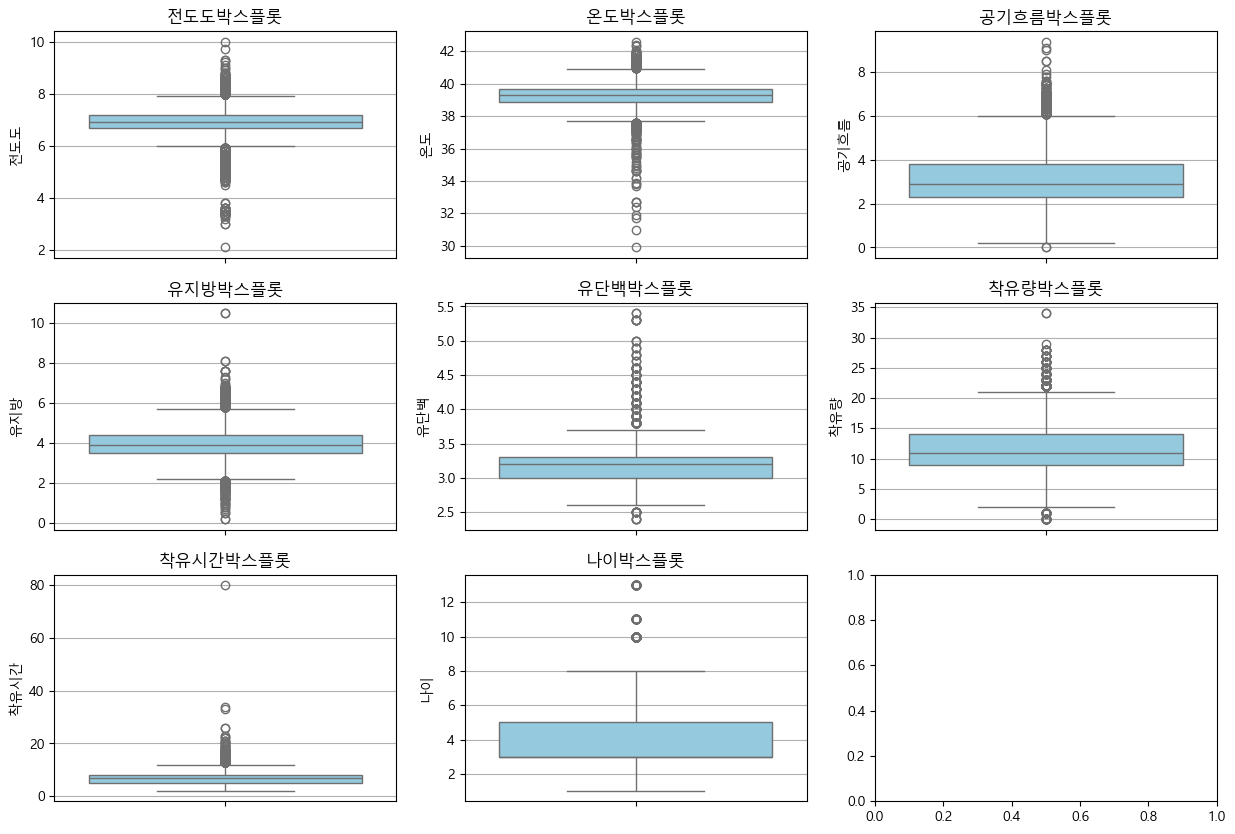

In [227]:
columns = ["전도도","온도","공기흐름","유지방","유단백","착유량","착유시간","나이"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

axes = axes.flatten()

for i, col in enumerate(columns):

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr

    ax = axes[i]

    df_outlier = (df[col]<lower_bound) | (df[col]>upper_bound)

    print(f"{col} 이상치 개수 : {df_outlier.sum()}")
    sns.boxplot(y=df[col], ax=ax, color='skyblue')

    ax.set_title(f"{col}박스플롯")
    ax.grid(axis='y',alpha=1)

plt.show()


## 온도

In [244]:
df[df["온도"]<37.5].info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 2503 to 26450
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   농장아이디   81 non-null     int64         
 1   개체번호    81 non-null     int64         
 2   착유량     81 non-null     int64         
 3   착유시작일시  81 non-null     datetime64[ns]
 4   착유종료일시  81 non-null     datetime64[ns]
 5   착유회차    81 non-null     int64         
 6   전도도     81 non-null     float64       
 7   혈액흐름    81 non-null     int64         
 8   온도      81 non-null     float64       
 9   유지방     47 non-null     float64       
 10  유단백     47 non-null     float64       
 11  공기흐름    81 non-null     float64       
dtypes: datetime64[ns](2), float64(5), int64(5)
memory usage: 8.2 KB


In [283]:
a = df[df["유지방"].isnull()]
a

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름
4210,20338,20161021020021,0,2021-09-08 04:58:00,2021-09-08 05:01:00,1,7.0,0,34.6,NaN,NaN,0.2
4213,20338,20161021020021,1,2021-09-08 16:11:00,2021-09-08 16:15:00,2,6.6,0,38.1,NaN,NaN,1.6
4217,20338,20161021020021,1,2021-09-10 02:30:00,2021-09-10 02:35:00,1,6.6,0,37.0,NaN,NaN,1.8
4219,20338,20161021020021,1,2021-09-11 01:39:00,2021-09-11 01:44:00,1,6.6,0,36.8,NaN,NaN,1.8
4238,20338,20161021020021,0,2021-09-21 05:00:00,2021-09-21 05:06:00,1,4.7,0,32.4,NaN,NaN,0.3
4240,20338,20161021020021,0,2021-09-23 16:18:00,2021-09-23 16:24:00,1,2.1,0,31.9,NaN,NaN,0.4
6017,20338,20170524020105,1,2021-09-05 17:39:00,2021-09-05 17:44:00,2,6.4,0,37.1,NaN,NaN,1.2
6075,20338,20170524020105,2,2021-09-21 21:20:00,2021-09-21 21:24:00,2,6.8,0,37.2,NaN,NaN,1.4
7175,20338,20171228020140,9,2021-09-24 06:52:00,2021-09-24 06:59:00,1,6.4,0,38.1,NaN,NaN,1.7
11304,20338,20190226020041,1,2021-09-21 06:39:00,2021-09-21 06:43:00,3,6.6,0,37.4,NaN,NaN,0.7


In [ ]:
b = df[(df["온도"]<37.5) & (df["유지방"].isnull())] 

In [278]:
b_index = b.index

a_exclude = a.drop(b_index)
a_exclude

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름
4213,20338,20161021020021,1,2021-09-08 16:11:00,2021-09-08 16:15:00,2,6.6,0,38.1,NaN,NaN,1.6
7175,20338,20171228020140,9,2021-09-24 06:52:00,2021-09-24 06:59:00,1,6.4,0,38.1,NaN,NaN,1.7
16265,20279,20170722010012,1,2021-09-05 13:40:00,2021-09-05 13:44:00,2,7.8,0,37.6,NaN,NaN,0.9
16280,20279,20170722010012,0,2021-09-12 14:57:00,2021-09-12 15:01:00,2,7.9,0,37.9,NaN,NaN,0.8
17889,20332,20190307020022,3,2021-09-19 07:10:00,2021-09-19 07:17:00,1,7.8,0,38.6,NaN,NaN,1.2
17890,21133,20190305010086,3,2021-09-19 07:10:00,2021-09-19 07:17:00,1,7.8,0,38.6,NaN,NaN,1.2
21613,21133,20180127010011,1,2021-09-25 05:48:00,2021-09-25 05:54:00,2,7.0,0,37.6,NaN,NaN,1.3
21614,20332,20180127020089,1,2021-09-25 05:48:00,2021-09-25 05:54:00,2,7.0,0,37.6,NaN,NaN,1.3


In [246]:
df[df["온도"]>41].info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 58 to 27891
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   농장아이디   173 non-null    int64         
 1   개체번호    173 non-null    int64         
 2   착유량     173 non-null    int64         
 3   착유시작일시  173 non-null    datetime64[ns]
 4   착유종료일시  173 non-null    datetime64[ns]
 5   착유회차    173 non-null    int64         
 6   전도도     173 non-null    float64       
 7   혈액흐름    173 non-null    int64         
 8   온도      173 non-null    float64       
 9   유지방     173 non-null    float64       
 10  유단백     173 non-null    float64       
 11  공기흐름    173 non-null    float64       
dtypes: datetime64[ns](2), float64(5), int64(5)
memory usage: 17.6 KB


## 공기흐름

In [332]:
c = df[(df["공기흐름"]>=3) & (df["공기흐름"]<4.1)]

In [333]:
c["착유량"].mean()

np.float64(11.900802221536562)

In [334]:
df[df["공기흐름"]==9.4]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름
25198,20264,20170810020047,12,2021-09-07 02:26:00,2021-09-07 02:33:00,1,7.1,0,39.1,4.1,3.1,9.4


In [336]:
df["착유시간"] = df["착유종료일시"]-df["착유시작일시"]

In [337]:
df["착유시간"]  = df["착유시간"].dt.total_seconds() / 60  # 분 단위로 변환

In [357]:
df[(df["착유시간"] > 15) & (df["공기흐름"]<5)]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
235,20278,20150218010032,26,2021-09-26 16:23:00,2021-09-26 16:41:00,2,6.8,0,40.2,5.4,3.1,1.7,18.0
961,20278,20170710010068,19,2021-09-17 07:05:00,2021-09-17 07:21:00,1,7.7,0,40.6,4.9,3.4,1.4,16.0
962,20278,20170710010068,24,2021-09-18 06:00:00,2021-09-18 06:16:00,1,8.2,0,40.5,4.2,3.3,1.9,16.0
2532,20338,20150102020102,15,2021-09-26 08:04:00,2021-09-26 09:24:00,1,6.5,0,38.7,4.1,3.7,3.5,80.0
3468,20338,20160927020016,13,2021-09-21 08:45:00,2021-09-21 09:01:00,2,6.9,0,39.0,3.3,3.2,2.9,16.0
3741,20338,20161010020156,18,2021-09-06 00:44:00,2021-09-06 01:00:00,1,7.8,0,39.3,3.3,3.1,1.9,16.0
3747,20338,20161010020156,24,2021-09-07 06:38:00,2021-09-07 06:54:00,1,8.1,0,39.0,2.5,3.3,1.7,16.0
3820,20338,20161010020156,20,2021-09-24 08:03:00,2021-09-24 08:20:00,1,7.8,0,37.9,2.4,3.4,1.6,17.0
3831,20338,20161010020156,34,2021-09-26 18:21:00,2021-09-26 18:38:00,1,7.8,0,39.3,1.6,3.7,2.4,17.0
4195,20338,20161021020021,3,2021-09-02 06:01:00,2021-09-02 06:35:00,1,6.4,0,38.1,4.6,3.7,3.5,34.0


In [365]:
df[(df["착유시간"]>=20) & (df["착유회차"]==1)]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
2532,20338,20150102020102,15,2021-09-26 08:04:00,2021-09-26 09:24:00,1,6.5,0,38.7,4.1,3.7,3.5,80.0
4195,20338,20161021020021,3,2021-09-02 06:01:00,2021-09-02 06:35:00,1,6.4,0,38.1,4.6,3.7,3.5,34.0
23758,20264,20140315020075,14,2021-09-23 02:34:00,2021-09-23 02:54:00,1,7.7,0,37.7,3.9,3.2,1.0,20.0
26819,20264,20180821020070,16,2021-09-22 05:57:00,2021-09-22 06:18:00,1,7.1,0,38.8,4.5,2.9,1.1,21.0
27442,20264,20190701020010,7,2021-09-08 17:29:00,2021-09-08 17:50:00,1,7.4,0,39.0,4.4,3.7,1.8,21.0


In [400]:
df[df["공기흐름"]<1].head(10)

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
1793,20278,20180903010007,3,2021-09-21 07:24:00,2021-09-21 07:30:00,1,7.9,0,39.9,0.6,3.8,0.9,6.0
1794,20278,20180903010007,3,2021-09-21 17:09:00,2021-09-21 17:18:00,2,7.6,0,38.7,0.9,3.8,0.8,9.0
2503,20338,20150102020102,1,2021-09-19 10:45:00,2021-09-19 11:00:00,1,7.1,0,34.2,1.0,3.9,0.6,15.0
4210,20338,20161021020021,0,2021-09-08 04:58:00,2021-09-08 05:01:00,1,7.0,0,34.6,NaN,NaN,0.2,3.0
4228,20338,20161021020021,0,2021-09-14 16:39:00,2021-09-14 16:42:00,2,8.2,0,36.9,5.9,3.7,0.6,3.0
4233,20338,20161021020021,1,2021-09-16 16:41:00,2021-09-16 16:45:00,1,7.6,0,37.7,5.5,3.9,0.8,4.0
4234,20338,20161021020021,0,2021-09-17 04:38:00,2021-09-17 04:42:00,1,9.3,0,35.6,6.7,3.2,0.4,4.0
4237,20338,20161021020021,0,2021-09-19 16:21:00,2021-09-19 16:26:00,1,7.6,0,35.8,6.2,3.8,0.7,5.0
4238,20338,20161021020021,0,2021-09-21 05:00:00,2021-09-21 05:06:00,1,4.7,0,32.4,NaN,NaN,0.3,6.0
4240,20338,20161021020021,0,2021-09-23 16:18:00,2021-09-23 16:24:00,1,2.1,0,31.9,NaN,NaN,0.4,6.0


In [401]:
df[df["개체번호"]==20161021020021]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
4193,20338,20161021020021,5,2021-09-01 06:21:00,2021-09-01 06:27:00,1,6.6,0,38.8,5.3,3.6,4.3,6.0
4195,20338,20161021020021,3,2021-09-02 06:01:00,2021-09-02 06:35:00,1,6.4,0,38.1,4.6,3.7,3.5,34.0
4197,20338,20161021020021,2,2021-09-02 15:59:00,2021-09-02 16:03:00,2,6.3,0,38.4,5.4,3.7,1.7,4.0
4199,20338,20161021020021,3,2021-09-03 04:17:00,2021-09-03 04:22:00,1,6.5,0,38.5,4.5,3.6,4.2,5.0
4201,20338,20161021020021,3,2021-09-03 16:22:00,2021-09-03 16:25:00,2,6.6,0,39.0,5.0,3.7,2.6,3.0
4202,20338,20161021020021,3,2021-09-04 16:20:00,2021-09-04 16:25:00,1,6.6,0,38.8,5.1,3.7,2.5,5.0
4205,20338,20161021020021,2,2021-09-06 01:53:00,2021-09-06 01:58:00,1,6.4,0,37.5,5.6,3.6,2.7,5.0
4206,20338,20161021020021,2,2021-09-06 13:31:00,2021-09-06 13:36:00,2,6.3,0,38.5,5.3,3.7,3.1,5.0
4208,20338,20161021020021,4,2021-09-07 16:11:00,2021-09-07 16:15:00,1,7.3,0,38.4,4.8,3.7,3.7,4.0
4210,20338,20161021020021,0,2021-09-08 04:58:00,2021-09-08 05:01:00,1,7.0,0,34.6,NaN,NaN,0.2,3.0


# 분포 확인 (기존과 log변환 후)

In [129]:
df.columns

Index(['농장아이디', '개체번호', '측정일시', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도',
       '혈액흐름', '온도', '유지방', '유단백', '공기흐름', '수집일자', '착유시간', '나이', '측정일',
       '개체별 일일착유량', '개체별 착유일수'],
      dtype='object')

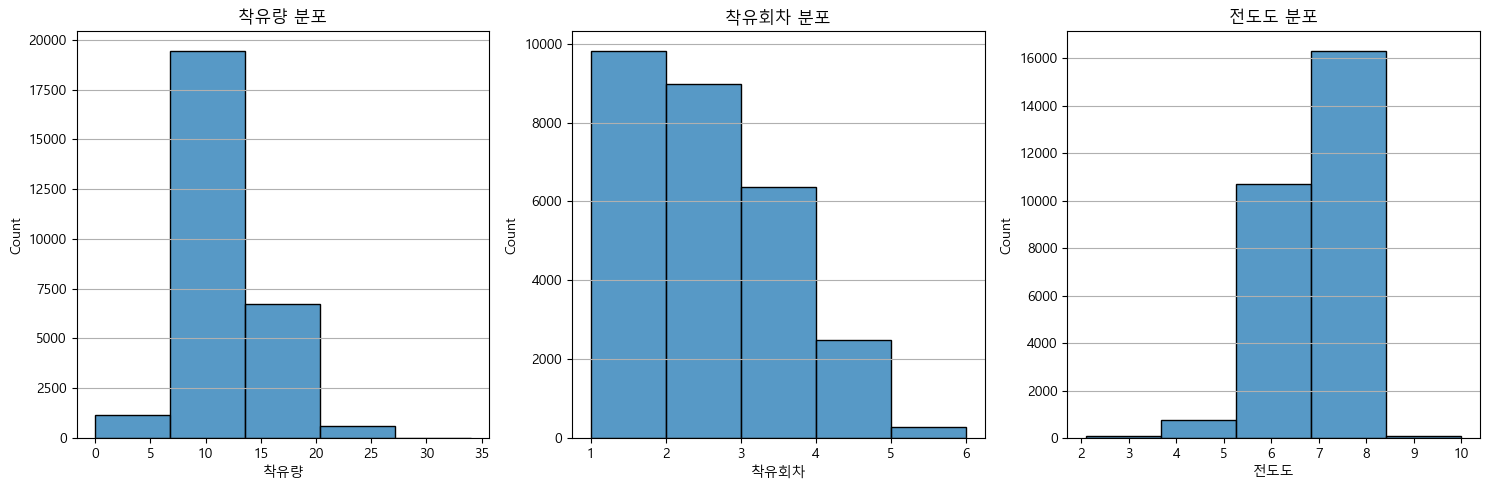

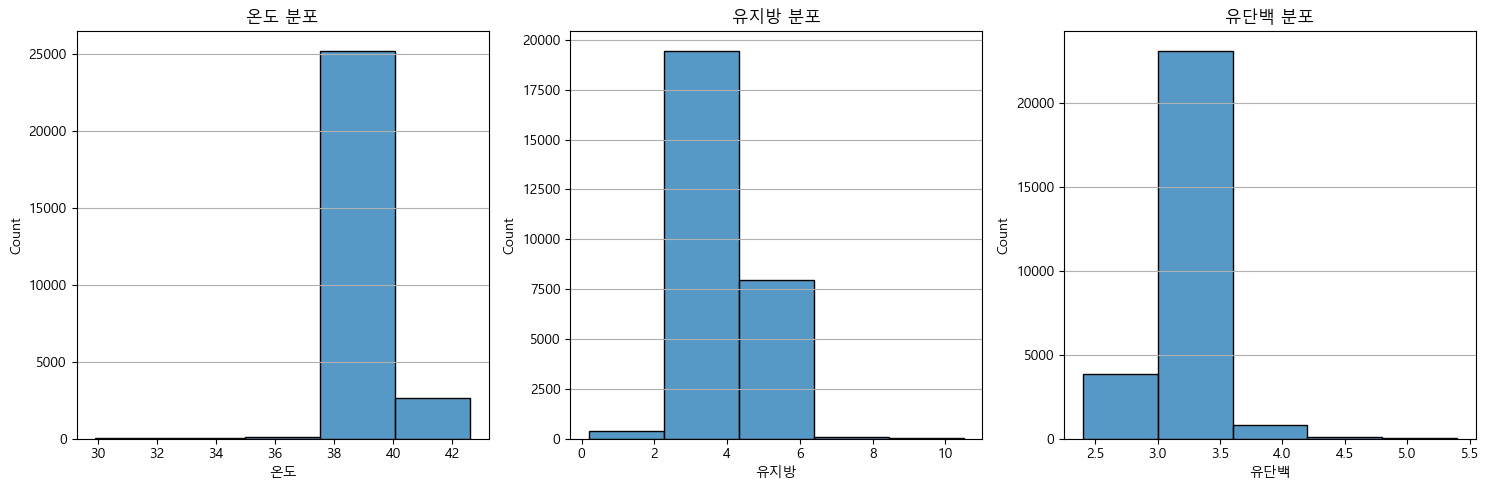

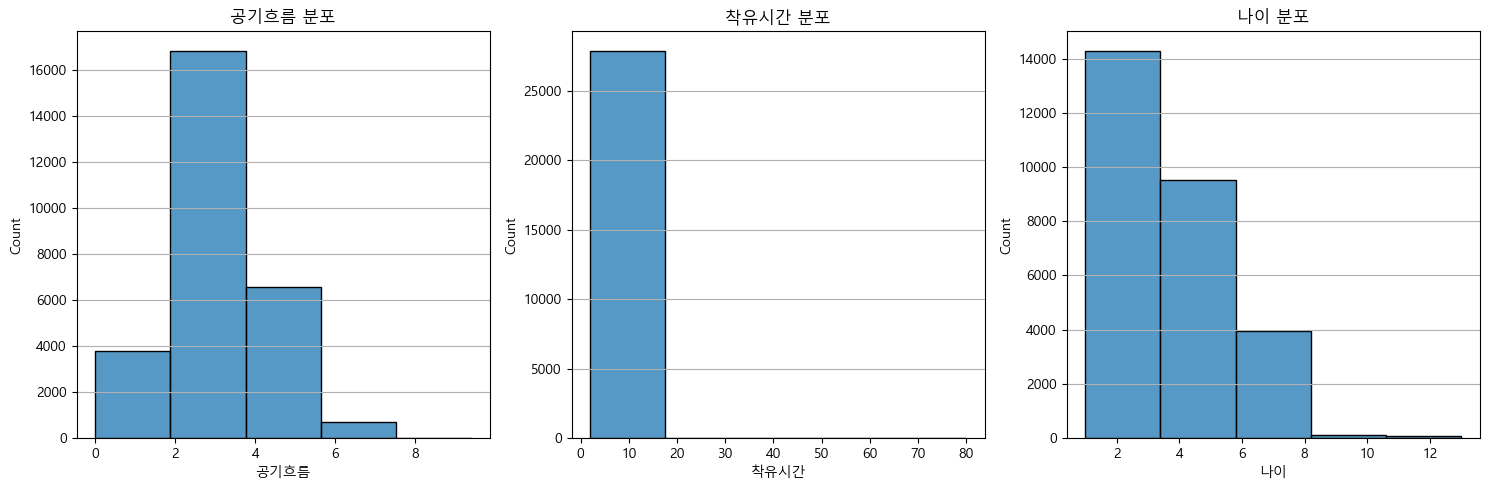

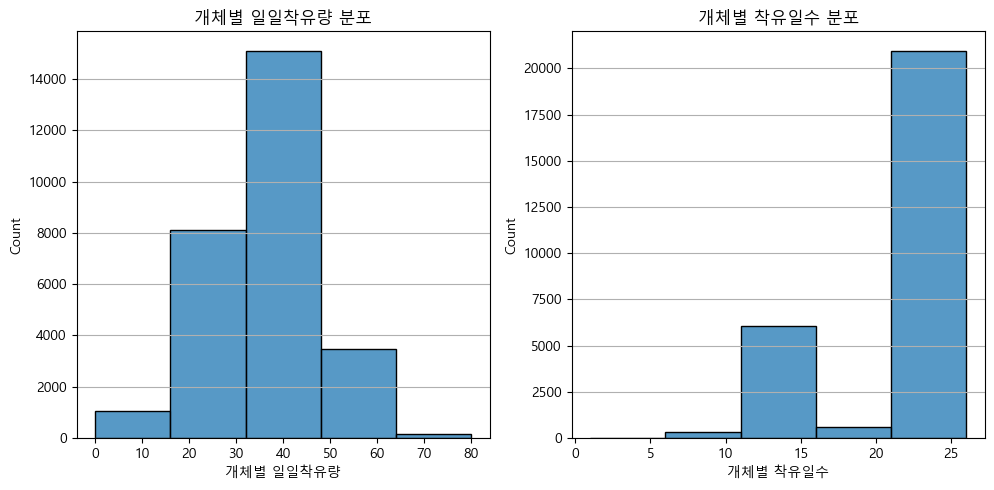

In [130]:
cols = ["전도도","온도","공기흐름","유지방","유단백","착유량","착유시간","나이","개체별 일일착유량","개체별 착유일수"]

cols_group = [["착유량","착유회차","전도도"],["온도","유지방","유단백"],["공기흐름","착유시간","나이"],["개체별 일일착유량","개체별 착유일수"]]

for x, y in enumerate(cols_group):
    plt.figure(figsize=(15,5))
    
    for i, col in enumerate(y):
        plt.subplot(1,3,i+1)
        sns.histplot(data=df, x=col, bins=5)
        plt.title(f"{col} 분포")
        plt.grid(axis='y', alpha=1)
    plt.tight_layout()
    plt.show()

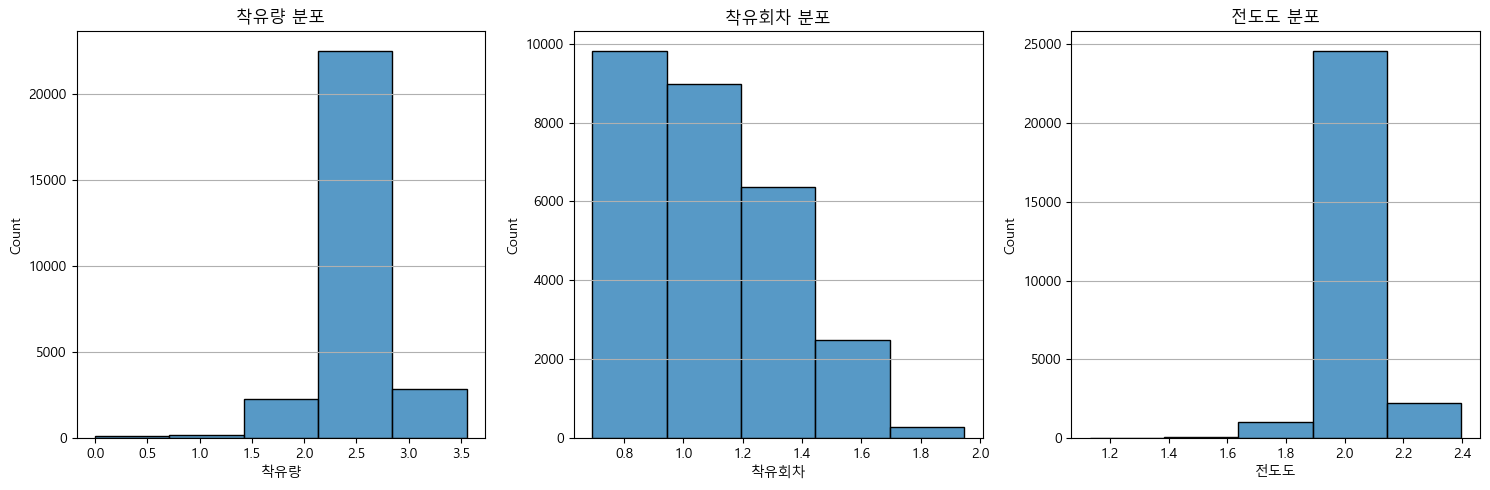

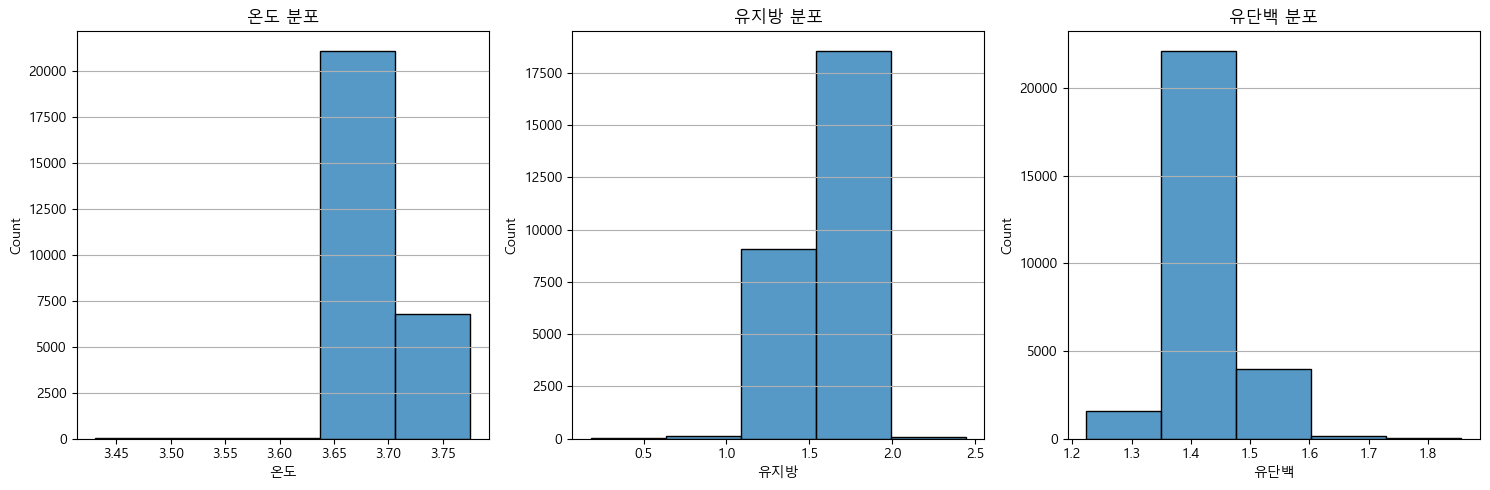

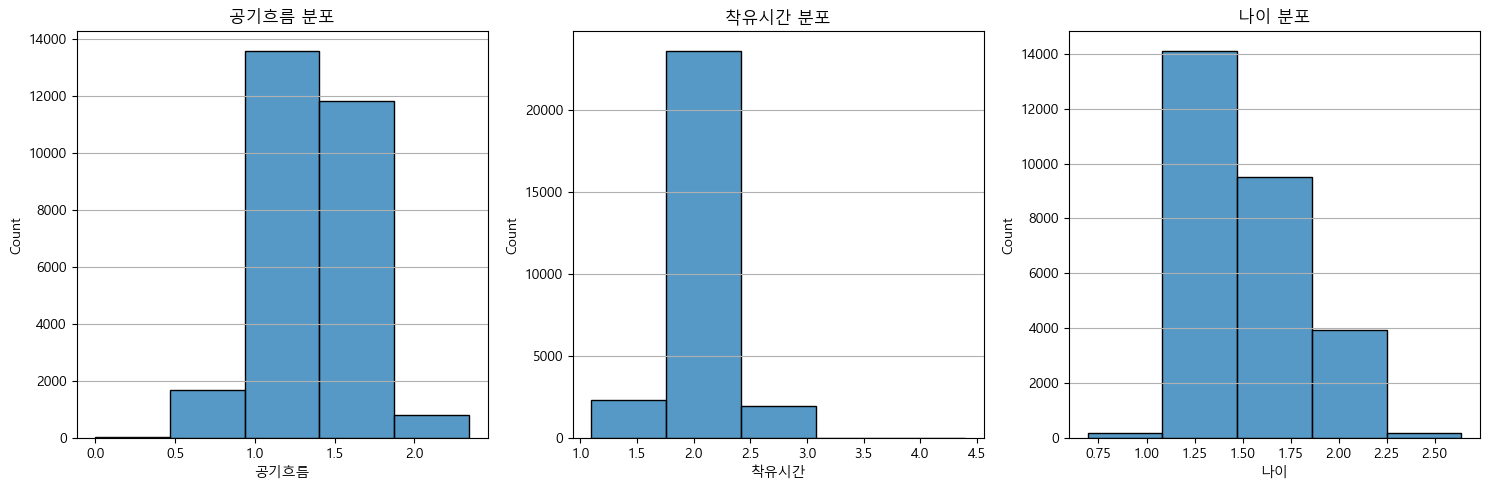

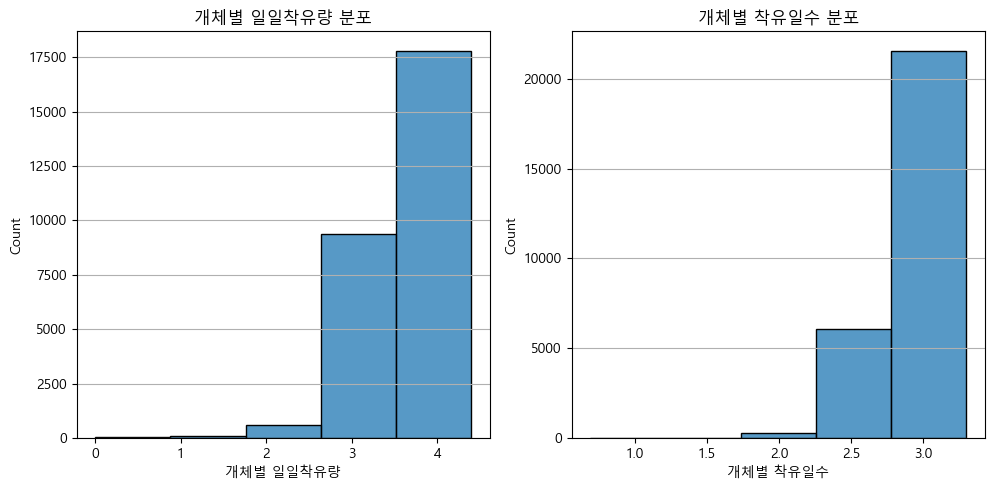

In [131]:
cols = ["전도도","온도","공기흐름","유지방","유단백","착유량","착유시간","나이","개체별 일일착유량","개체별 착유일수"]

cols_group = [["착유량","착유회차","전도도"],["온도","유지방","유단백"],["공기흐름","착유시간","나이"],["개체별 일일착유량","개체별 착유일수"]]

for x, y in enumerate(cols_group):
    plt.figure(figsize=(15,5))
    
    for i, col in enumerate(y):
        plt.subplot(1,3,i+1)

        log_transformed_col = np.log(df[col]+1)
        df[f"{col}_log"] = log_transformed_col
        sns.histplot(data=log_transformed_col, bins=5)
        plt.title(f"{col} 분포")
        plt.grid(axis='y', alpha=1)
    plt.tight_layout()
    plt.show()

In [132]:
df.head()

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,착유시간,나이,측정일,개체별 일일착유량,개체별 착유일수,착유량_log,착유회차_log,전도도_log,온도_log,유지방_log,유단백_log,공기흐름_log,착유시간_log,나이_log,개체별 일일착유량_log,개체별 착유일수_log
0,20278,20130816010079,2021-09-01 06:52:00,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5,20210902,12.0,8,1,33,26,2.833213,0.693147,2.091864,3.711130,1.629241,1.458615,0.916291,2.564949,2.197225,3.526361,3.295837
1,20278,20130816010079,2021-09-01 17:02:00,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1,20210902,9.0,8,1,33,26,2.890372,1.098612,2.054124,3.718438,1.704748,1.435085,1.131402,2.302585,2.197225,3.526361,3.295837
2,20278,20130816010079,2021-09-02 01:41:00,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9,20210903,10.0,8,2,35,26,2.708050,0.693147,2.054124,3.711130,1.757858,1.410987,1.064711,2.397895,2.197225,3.583519,3.295837
3,20278,20130816010079,2021-09-02 07:28:00,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7,20210903,8.0,8,2,35,26,2.397895,1.098612,2.054124,3.703768,1.791759,1.410987,0.993252,2.197225,2.197225,3.583519,3.295837
4,20278,20130816010079,2021-09-02 14:33:00,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3,20210903,12.0,8,2,35,26,2.484907,1.386294,2.054124,3.713572,1.740466,1.435085,0.832909,2.564949,2.197225,3.583519,3.295837


# 기본적인 전처리 후 xgboost 돌려보기 (기존, log변환 후)

In [135]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수

X = df[["전도도","온도","공기흐름","유지방","유단백","착유량","착유시간","나이","개체별 착유일수"]]
y = df['착유량']

# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

# --- XGBoost 모델 생성 및 학습 ---
model = xgb.XGBRegressor(
    objective='reg:squarederror', # 회귀 문제를 위한 손실 함수
    n_estimators=100, # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=6, # 트리의 최대 깊이
    random_state=42, # 재현성을 위한 랜덤 시드
    tree_method='auto', # 트리 생성 방법 (자동 선택)
    eval_metric='rmse' # 평가 지표 (Root Mean Squared Error)
)
print("\n--- XGBoost 모델 학습 시작 ---")
model.fit(X_train, y_train)
print("--- XGBoost 모델 학습 완료 ---")
print("-" * 40)

# 검증 세트에 대한 예측
y_pred = model.predict(X_test)

# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print("-" * 40)

학습 데이터 X_train 형태: (22340, 9)
검증 데이터 X_test 형태: (5586, 9)
----------------------------------------

--- XGBoost 모델 학습 시작 ---
--- XGBoost 모델 학습 완료 ---
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R-squared (R2): 1.00
----------------------------------------


In [97]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수

X = df[["착유회차_log","전도도_log","온도_log","유지방_log","유단백_log","공기흐름_log","착유시간_log","나이_log"]]
y = df['착유량']

# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

# --- XGBoost 모델 생성 및 학습 ---
model = xgb.XGBRegressor(
    objective='reg:squarederror', # 회귀 문제를 위한 손실 함수
    n_estimators=100, # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=6, # 트리의 최대 깊이
    random_state=42, # 재현성을 위한 랜덤 시드
    tree_method='auto', # 트리 생성 방법 (자동 선택)
    eval_metric='rmse' # 평가 지표 (Root Mean Squared Error)
)
print("\n--- XGBoost 모델 학습 시작 ---")
model.fit(X_train, y_train)
print("--- XGBoost 모델 학습 완료 ---")
print("-" * 40)

# 검증 세트에 대한 예측
y_pred = model.predict(X_test)

# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print("-" * 40)

학습 데이터 X_train 형태: (22340, 8)
검증 데이터 X_test 형태: (5586, 8)
----------------------------------------

--- XGBoost 모델 학습 시작 ---
--- XGBoost 모델 학습 완료 ---
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 3.27
Root Mean Squared Error (RMSE): 1.81
R-squared (R2): 0.77
----------------------------------------


In [98]:
# df[(df["온도"]<38.8) & (df["유지방"].isnull())]

In [99]:
# df[df["혈액흐름"]==1]